In [39]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pingouin
import seaborn as sns

wine=load_wine()
n_classes = len(wine['target_names'])
data_shape = wine['data'].shape

w_pd = pd.DataFrame(np.c_[wine['data'], wine['target']], columns=wine['feature_names']+['target'])
w_pd = w_pd.rename(columns={'od280/od315_of_diluted_wines': 'od280/od315'})

X_train, X_test, y_train, y_test = train_test_split(w_pd.iloc[:,:-1], w_pd['target'], test_size=0.3, random_state=42)
print(w_pd)
print(f'Количество классов {n_classes}, форма данных {data_shape}')

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyan

In [40]:
print(wine['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

## Разведочный анализ

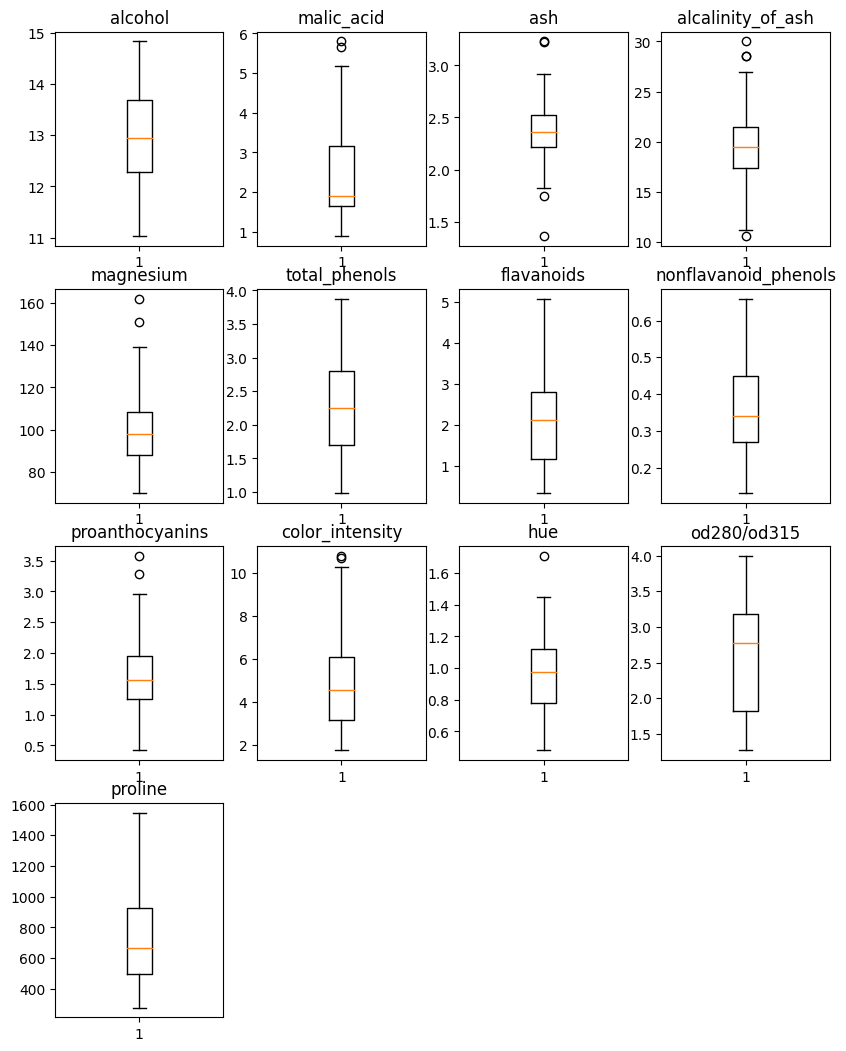

In [41]:
plt.figure(figsize=(10, 12.8))
for i, column in enumerate(X_train.columns):
    plt.subplot(4,4,i+1)
    plt.boxplot(X_train[column])
    plt.title(column)
plt.show()

Многие переменные имеют выбросы, но, их, судя по диаграмме не очень много. Часть диаграмм симметричны и имеют не очень длинные усы. Некоторые же несимметричны или имеют длинные усы.

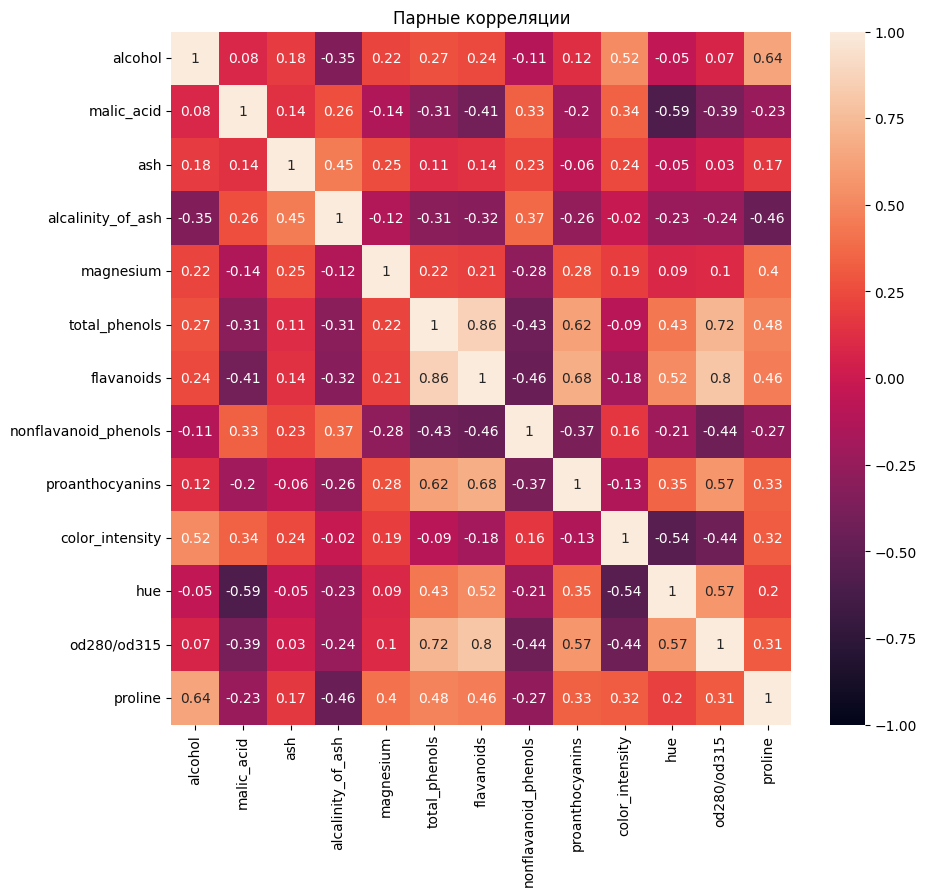

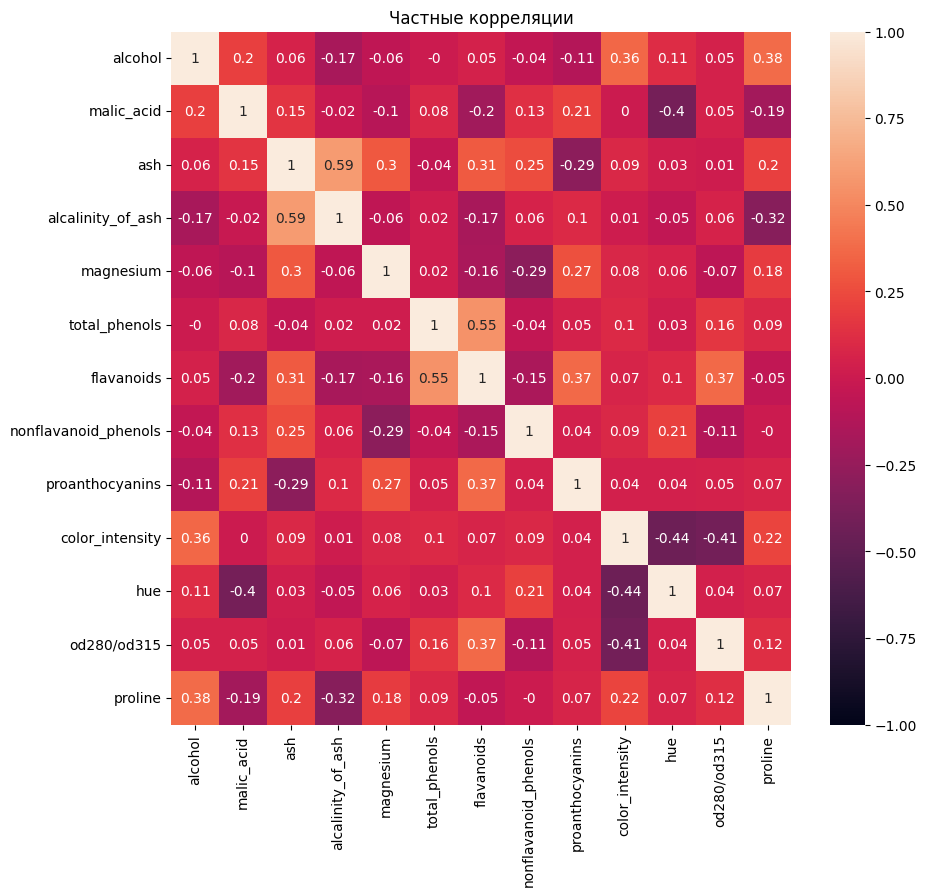

In [42]:
w_corr = X_train.corr()
w_pcorr = X_train.pcorr()
plt.figure(figsize=(10, 9))
sns.heatmap(w_corr.round(2), vmin=-1, vmax=1, annot=True)
plt.title('Парные корреляции')
plt.show()

plt.figure(figsize=(10, 9))
sns.heatmap(w_pcorr.round(2), vmin=-1, vmax=1, annot=True)
plt.title('Частные корреляции')
plt.show()

Некоторые характеристики имеют сильные💪 парные корреляции. Это значит, что можно попробовать предсказывать эти значения через линейную регрессию. Однако, большая часть параметров заметной линейной связи не показывают.

Информативность компонент: [0.36 0.19 0.12 0.08 0.07 0.05 0.04 0.03 0.02 0.02 0.02 0.01 0.01]
Информативность: 66.62%


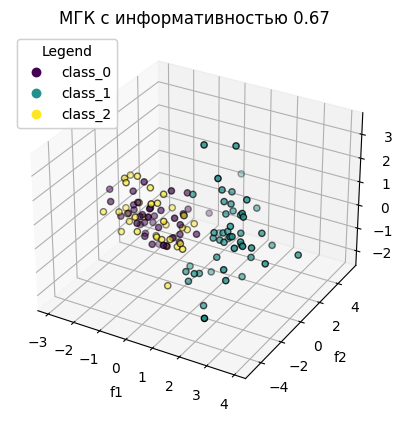

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

pca = PCA()
x_pca = pca.fit_transform(x_scaled, y_train)
x_test_pca = pca.transform(x_test_scaled)
data_delta = pca.explained_variance_ratio_
x_pca_pd = pd.DataFrame(x_pca, columns=[ f'f{i}' for i in range(len(X_train.columns))])
x_test_pca_pd = pd.DataFrame(x_test_pca, columns=[ f'f{i}' for i in range(len(X_test.columns))])

print(f'Информативность компонент: {(data_delta).round(2)}')
print(f'Информативность: {100*sum(data_delta[:3]):.2f}%')

def scatter3d(data_pd, columns, classes=None, classes_names=None, title=''):
    ax = plt.axes(projection='3d')

    x = data_pd[columns[0]]
    y = data_pd[columns[1]]
    z = data_pd[columns[2]]

    if classes_names is not None:
        scatter1 = ax.scatter(x, y, z, c=classes, marker='o', edgecolors=['000']*len(x))
        legend1 = ax.legend(*[scatter1.legend_elements()[0],classes_names], 
                            title="Legend", loc='upper left')
        ax.add_artist(legend1)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[2])
    plt.title(title)

scatter3d(x_pca_pd, columns=['f1','f2','f3'], classes=y_train, classes_names=wine['target_names'], title=f'МГК с информативностью {sum(data_delta[:3]):.2f}')
plt.show()

Полученное представление имеет не слишком большую информативность (окло 67%), но по ней всё равно можно сделать некоторые выводы, учитывая то, что она показывает не всю информацию о выборке. Так, здесь видно, что первый класс довольно хорошо должен отделяться от двух других, по скольку он находится в отдельном кластере. Также, по картинке можно предположить, что первый класс является линейно отделимым. Для задачи кластеризации видно два кластера.

c:\Users\smoll_zoa\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\smoll_zoa\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


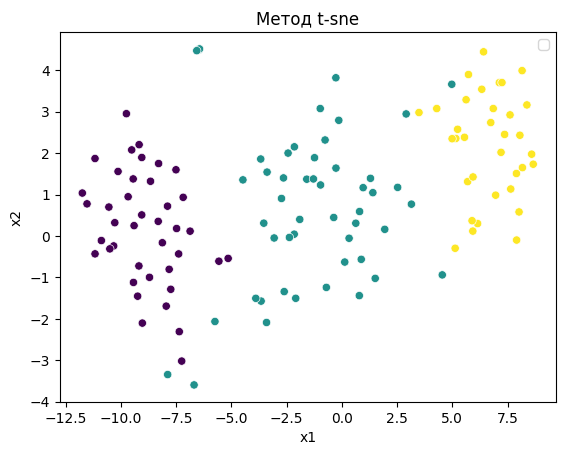

In [44]:
from sklearn.manifold import TSNE

t_sne = TSNE()
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(x_scaled)
tsne_data =pd.DataFrame(tsne_data,columns=['x1','x2'])
sns.scatterplot(data=tsne_data, x='x1', y='x2', c=y_train)
plt.title('Метод t-sne')
plt.legend()
plt.show()

В данном методе видно, что 3 класса довольно хорошо визуально разделимы. Значит, их классификация должна быть возможна и, при этом, с довольно большой хорошей разделимостью. Также на данном представлении видно 3 кластера, которые явно могут быть выделены.

In [45]:
from sklearn import linear_model

features = X_train.shape[1] - 1
n = X_train.shape[0]

y_columns = X_train.columns
l_regs = dict()
l_columns = dict()
data = dict()

#train
for col in y_columns:
    l_columns[col] = list(X_train.columns)
    l_columns[col].remove(col)
    X = X_train[l_columns[col]].values.reshape(-1, features)
    y = X_train[col].values.reshape(-1, 1)

    data[col] = (X, y)

    l_reg = linear_model.LinearRegression()
    l_reg.fit(X, y)
    l_regs[col] = l_reg


R_squared = dict()
std_coeffs = dict()
y_pred = dict()
RMSE = dict()

def get_std_coeffs(coeffs, std_pd, col, l_columns):
    scale = np.array([ std_pd[i] / std_pd[col] for i in l_columns[col] ])
    return pd.Series(data=(coeffs*scale).flatten(), index=l_columns[col])

#test
train_std = X_train.std(ddof=1)
for col in y_columns:
    X = X_train[l_columns[col]].values.reshape(-1, features)
    y = X_train[col].values.reshape(-1, 1)
    test_X = X_test[l_columns[col]].values.reshape(-1, features)
    test_y = X_test[col].values.reshape(-1, 1)
    
    R_squared[col] = l_regs[col].score(X, y)
    std_coeffs[col] = get_std_coeffs(l_regs[col].coef_, train_std, col, l_columns)
    y_pred = l_regs[col].predict(test_X)
    err = test_y - y_pred
    RMSE[col] = np.sqrt(err.T.dot(err) / n).item()
    

print("Коэффициенты детерминации по обучающей выборке")
print(pd.Series(R_squared))
print('\nRMSE по тестовой выборке')
print(pd.Series(RMSE))

print('\nКоэффициенты стандартизированных уравнений построенных регрессий')
print(pd.concat(std_coeffs, axis=1).round(2))

Коэффициенты детерминации по обучающей выборке
alcohol                 0.568887
malic_acid              0.463506
ash                     0.559340
alcalinity_of_ash       0.563521
magnesium               0.333205
total_phenols           0.767625
flavanoids              0.859803
nonflavanoid_phenols    0.407465
proanthocyanins         0.555500
color_intensity         0.667392
hue                     0.602526
od280/od315             0.748157
proline                 0.643946
dtype: float64

RMSE по тестовой выборке
alcohol                   0.296417
malic_acid                0.723383
ash                       0.133360
alcalinity_of_ash         1.406162
magnesium                 7.819086
total_phenols             0.186680
flavanoids                0.274670
nonflavanoid_phenols      0.058318
proanthocyanins           0.322052
color_intensity           1.047468
hue                       0.090987
od280/od315               0.247162
proline                 141.012374
dtype: float64

Коэффициенты

По полученным метрикам видно, что для нескольких параметров получились неплохие линейные регрессии (od280/od315, total_phenols, flavonoids), имеющие детерминацию более 0.7. Эти значения можно предсказывать по остальным. Также, стоит обратить внимание, что для некоторых параметров, получивших малое значение детерминации получены хорошие значения RMSE. Например, к ним можно отнести параметр hue. В целом, такое наблюдается для параметров имеющих выбросы. Также, получены стандартизированные уравнения для каждой из регрессий. По ним видно, что многие параметры в этих регрессиях малозначимы, и их можно исключить из регрессии упростив модель без значительного ухудшения качества.

## Классификация

Средние метрики для валидационных выборок
test_accuracy           0.937179
test_recall_micro       0.937179
test_recall_macro       0.935556
test_precision_micro    0.937179
test_precision_macro    0.950000
test_f1_micro           0.937179
test_f1_macro           0.937047
dtype: float64 

Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.91      0.95        23
           2       0.93      1.00      0.96        13

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



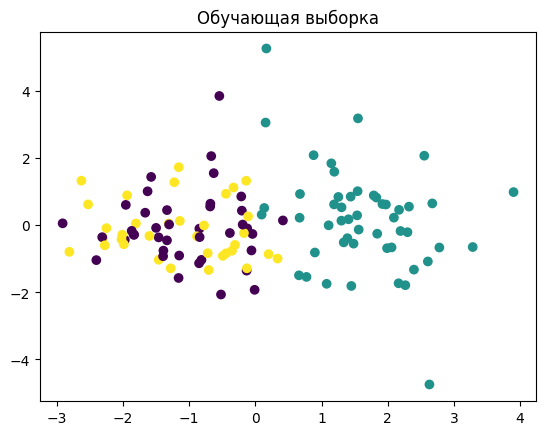

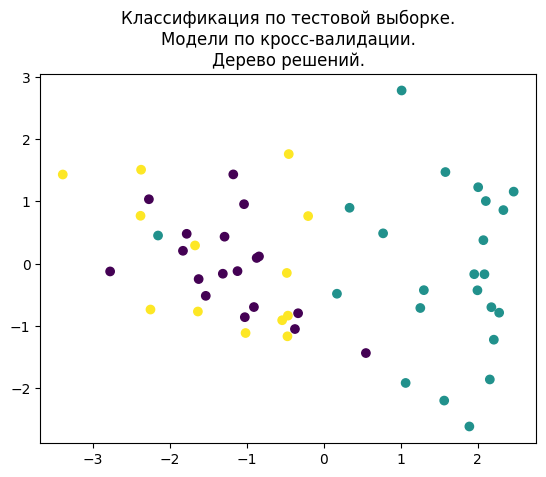

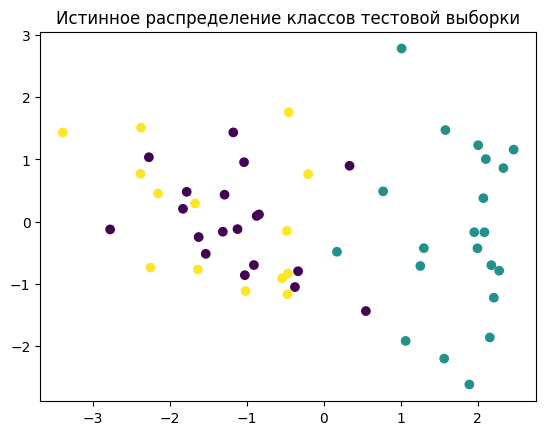

In [46]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn import tree

scores1 = ['accuracy', 'recall_micro', 'recall_macro', 'precision_micro', 'precision_macro', 'f1_micro', 'f1_macro']
n_classes = len(set(y_train))

def models_predict(models, X, n_classes):
    proba = np.zeros((X.shape[0], n_classes))
    for model in models:
        proba += model.predict_proba(X)
    proba /= len(models)
    y_pred = proba.argmax(axis=1)
    return y_pred
    
cross_validation_res = cross_validate(tree.DecisionTreeClassifier(max_depth=4), X_train, y_train, cv = 10, scoring = scores1, return_estimator=True)
scores=pd.DataFrame(cross_validation_res).drop(['fit_time', 'score_time', 'estimator'], axis=1).mean(axis=0)
models = cross_validation_res['estimator']
y_pred = models_predict(models, X_test, n_classes)
print('Средние метрики для валидационных выборок')
print(scores, '\n')

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nМодели по кросс-валидации.\nДерево решений.')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

In [47]:
from catboost import CatBoostClassifier
from catboost import metrics
custom_metric=[metrics.Accuracy(), metrics.F1(), metrics.Precision(), metrics.Recall()]

clf = CatBoostClassifier(
    random_seed=0,
    verbose=False,
    custom_metric = custom_metric
)
params = {'learning_rate': np.arange(0.03, 0.1, 0.01),
          'iterations': range(2, 10),
        'depth': range(2,6),
        'l2_leaf_reg': [1, 2]}

import os
import sys
a = sys.stdout
f = open(os.devnull, 'w')
grig_clf = clf.grid_search(params,X_train,y=y_train,cv=10,verbose=False,log_cout=f)
f.close()
print('Найденные лучшие параметры')

best_params = grig_clf.get('params')
print(pd.Series(best_params))

Найденные лучшие параметры
depth            3.0
l2_leaf_reg      1.0
iterations       9.0
learning_rate    0.1
dtype: float64


Метрики по тестовой выборке
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        21
         1.0       0.90      1.00      0.95        19
         2.0       1.00      1.00      1.00        14

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.97      0.96      0.96        54



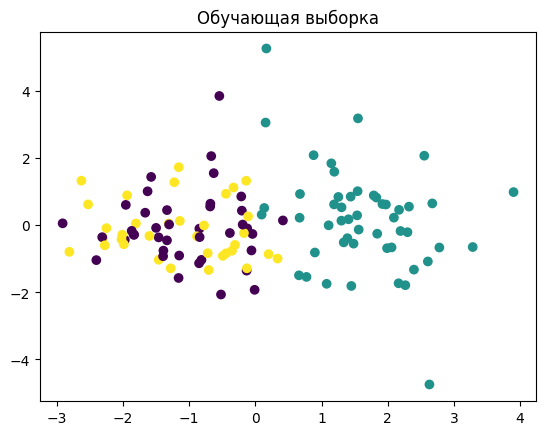

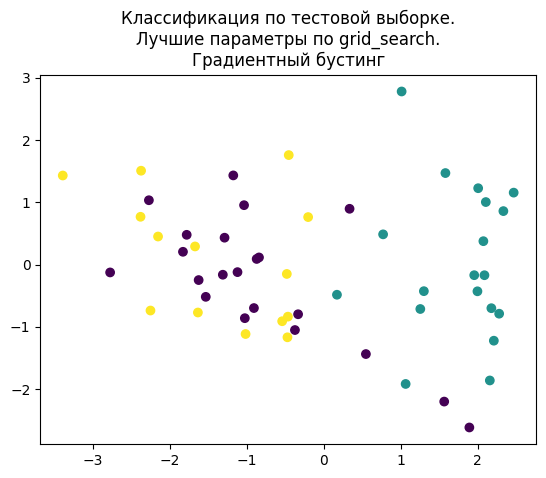

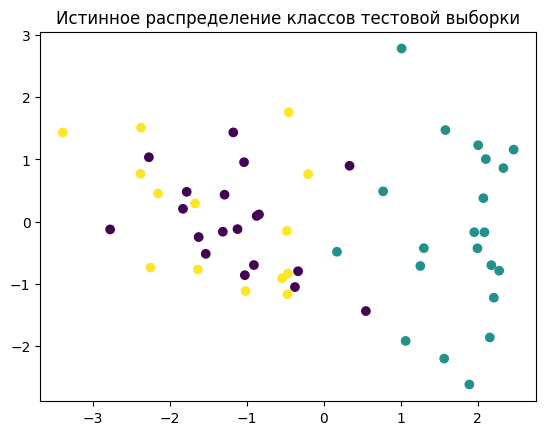

In [48]:
best_clf = CatBoostClassifier(
    random_seed=0,
    verbose=False,
    custom_metric = custom_metric,
    **best_params
)
best_clf.fit(X_train, y_train)
y_pred=best_clf.predict(X_test)

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nЛучшие параметры по grid_search.\nГрадиентный бустинг')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

## Кластеризация

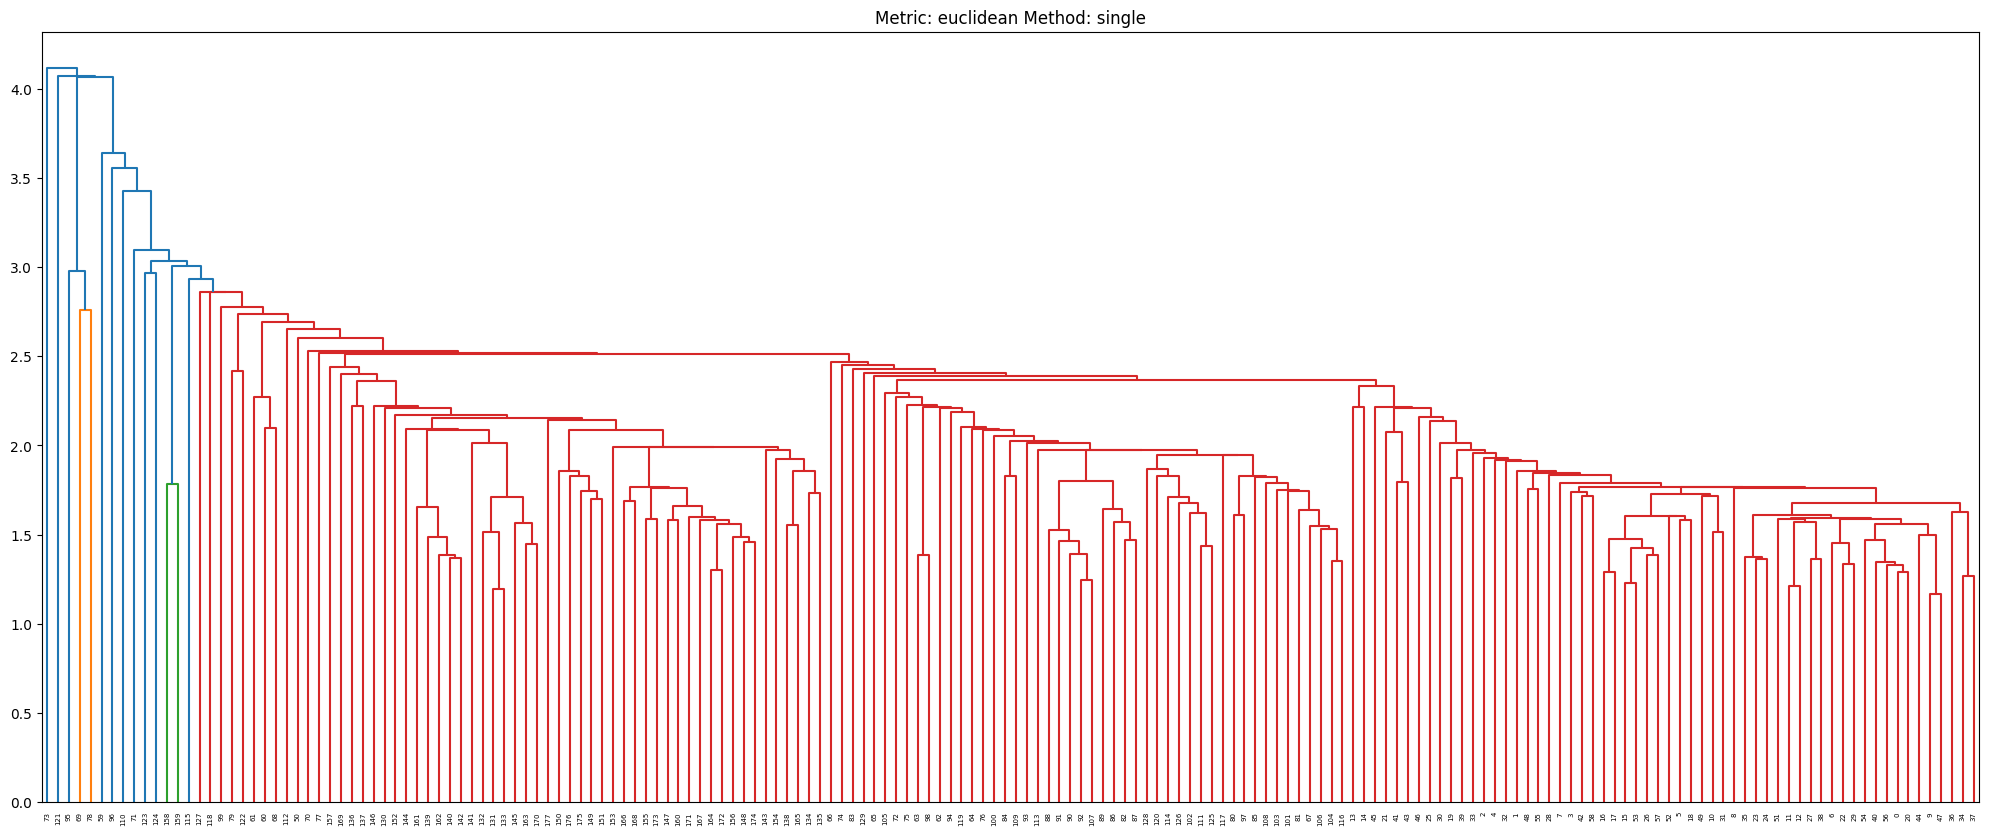

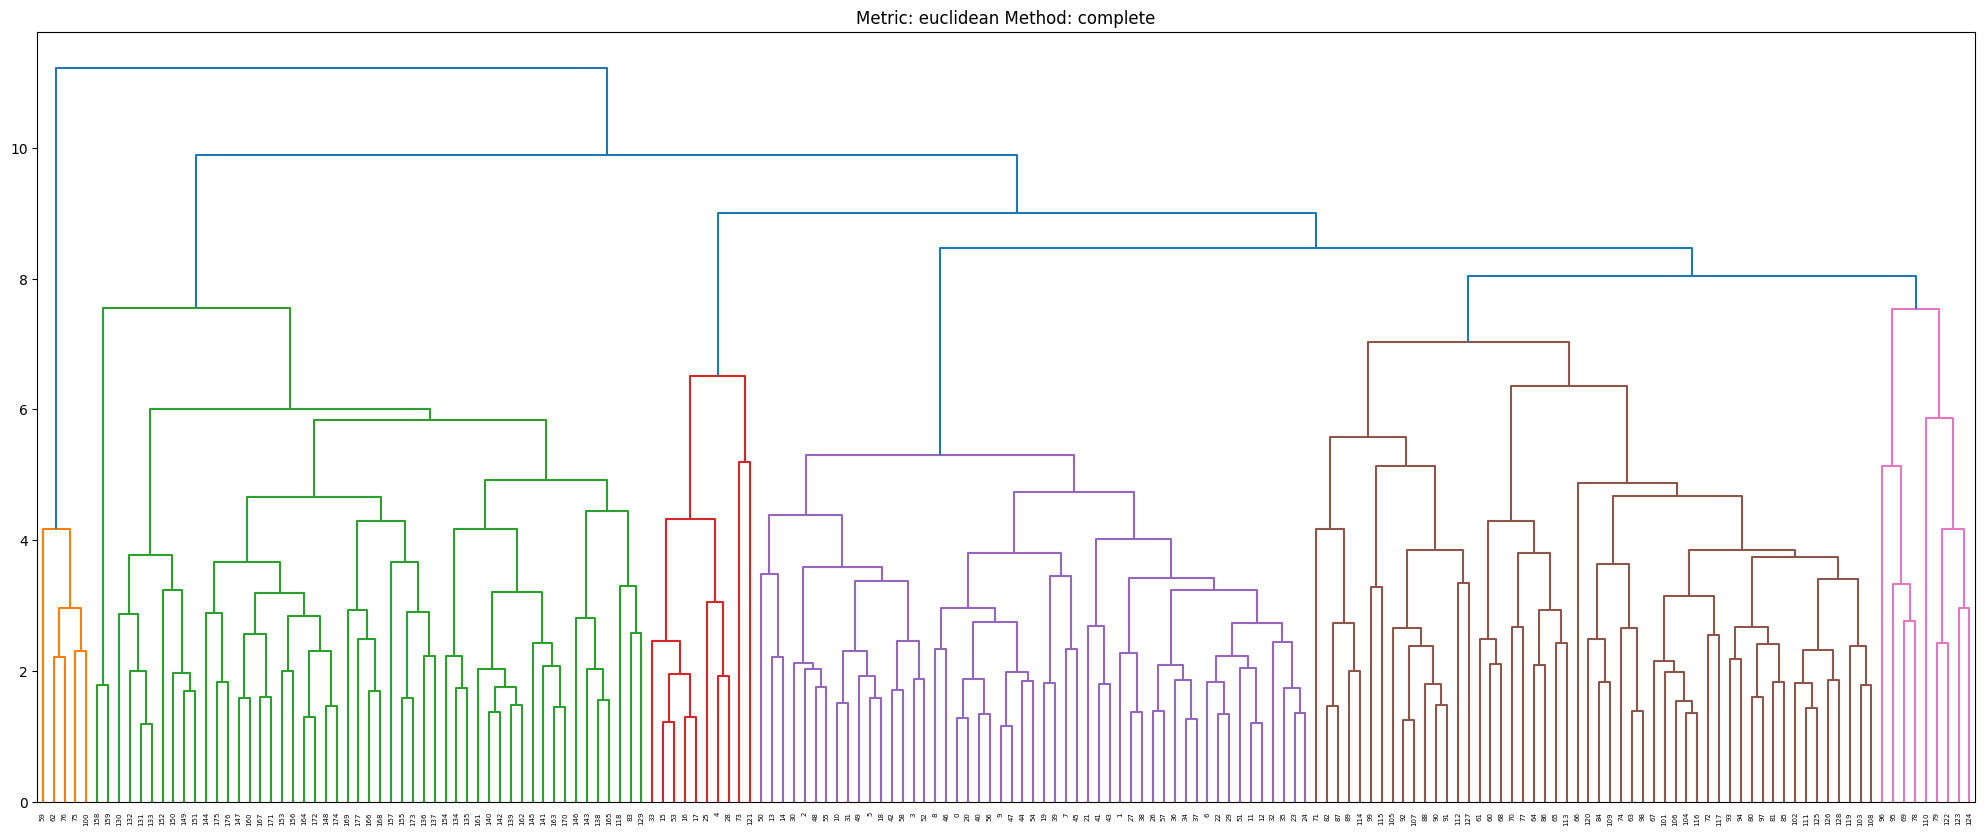

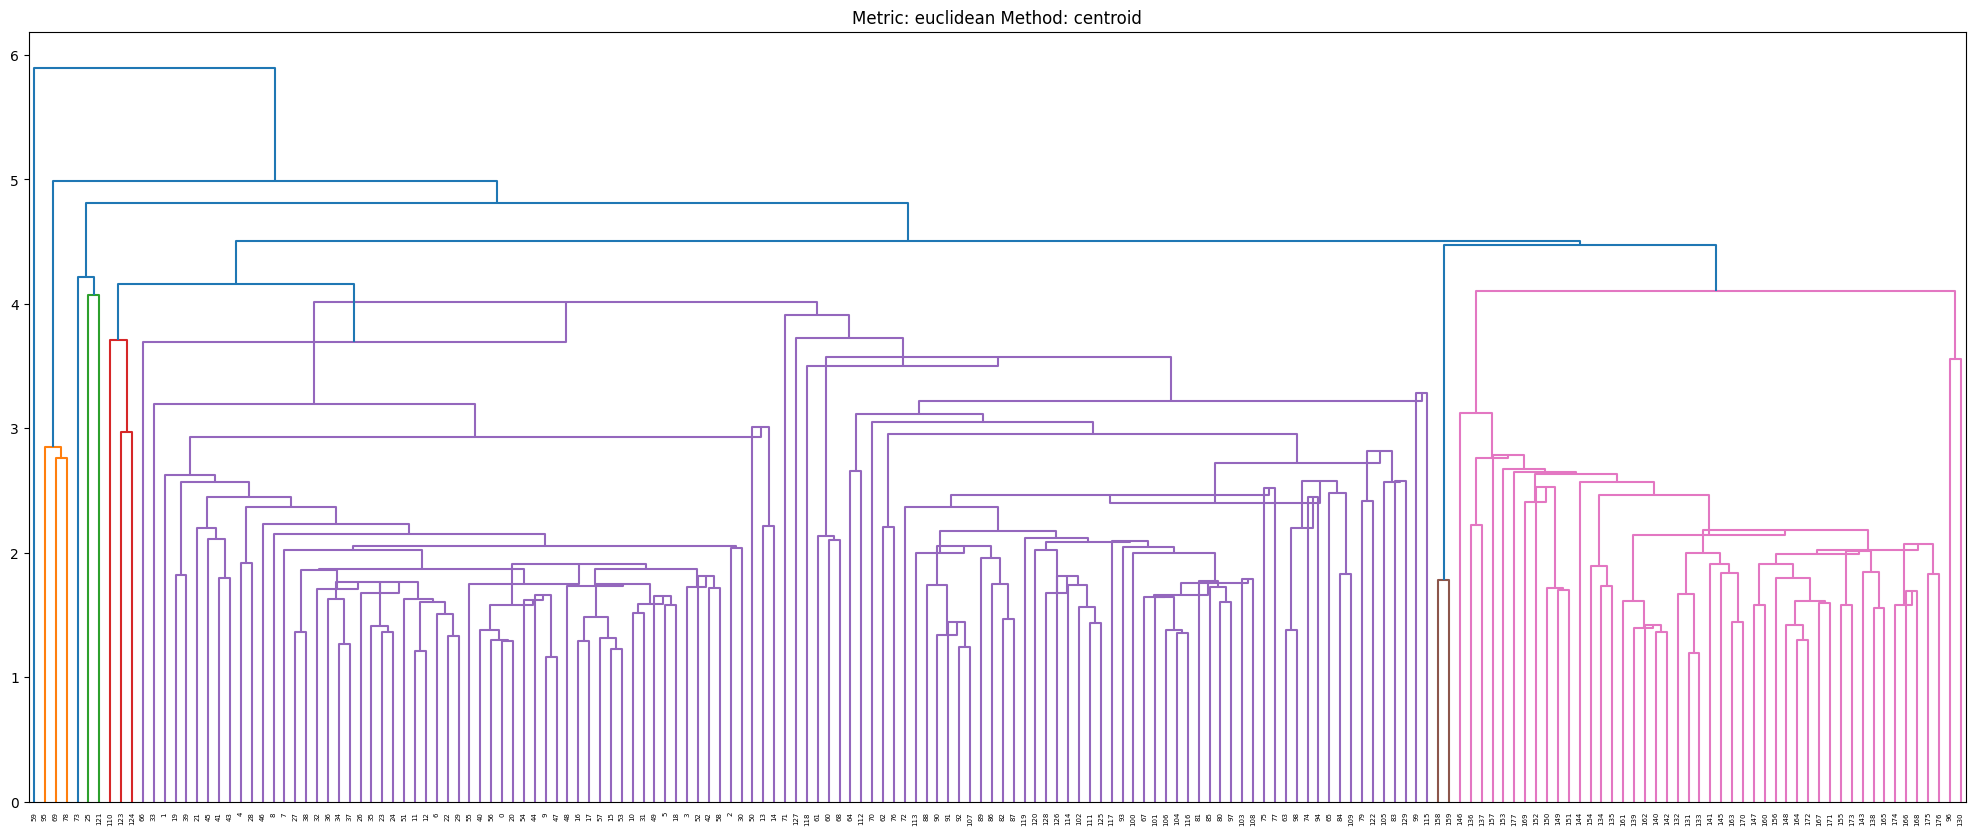

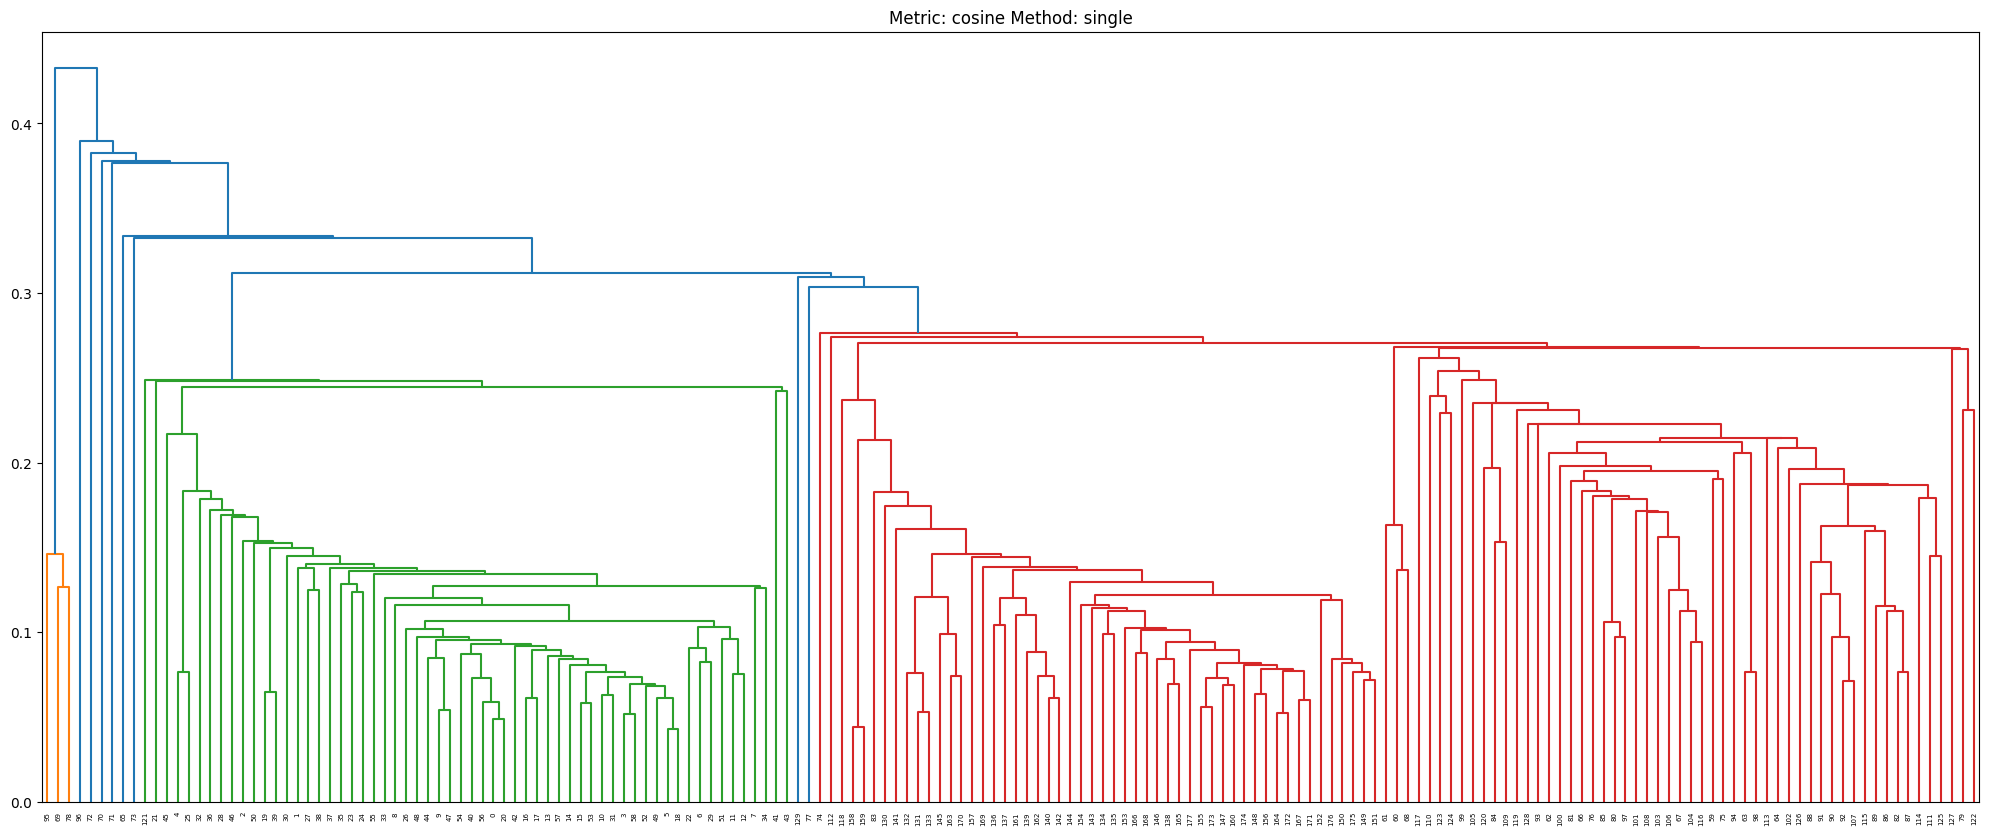

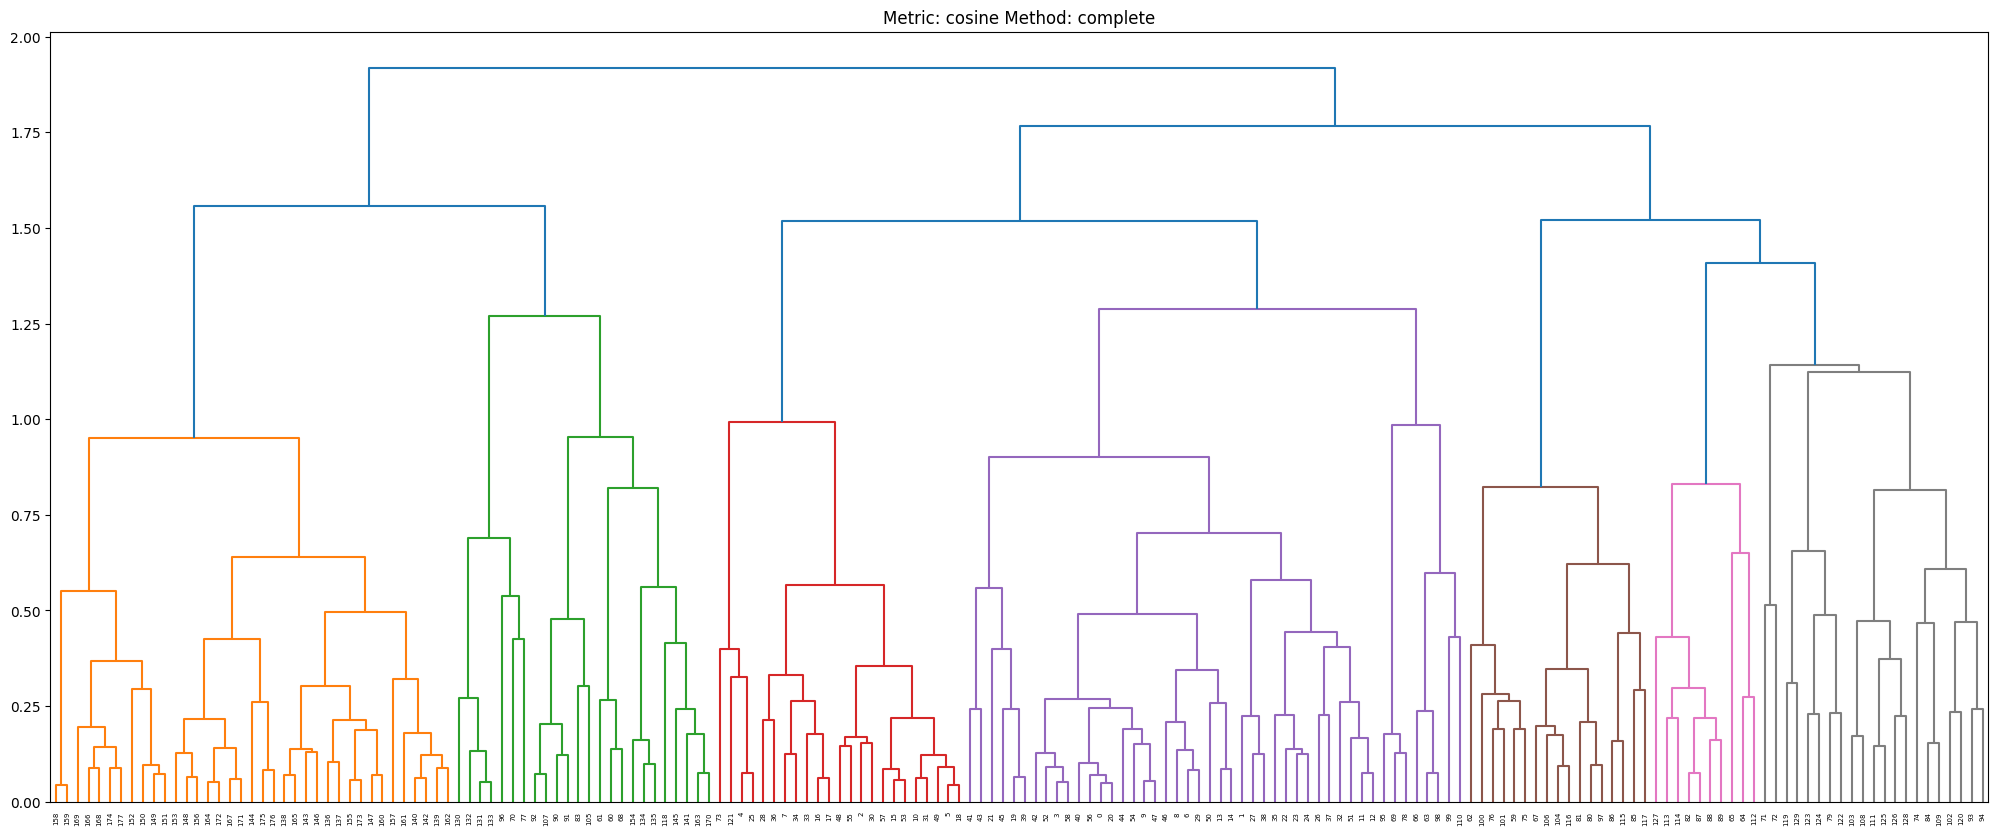

In [49]:
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogramm(w_pd, method, metric='euclidean'):
    cluster_ar = linkage(w_pd, method=method, metric=metric)
    link_df = pd.DataFrame(cluster_ar, index=[f'step {i+1}' for i in range(cluster_ar.shape[0])], columns=['cluster1', 'cluster2', 'dist', 'number elements'] )
    fig = plt.figure(figsize=(25,10))
    row_dendr = dendrogram(link_df)
    plt.title(f'Metric: {metric} Method: {method}')
    plt.show()

metrics = ['euclidean', 'cosine']
methods = ['single', 'complete', 'centroid']

scaler = StandardScaler()
w_pd_scaled = scaler.fit_transform(w_pd)
for metric in metrics:
    for method in methods:
        if method == 'centroid' and metric == 'cosine':
            continue

        plot_dendrogramm(w_pd_scaled, method, metric)

Для построения дендрограмм мы стандартизировали данные, чтобы влияние каждого параметра было одинаковым. Для разных методов объединения и метрик имеем весьма различные результаты. Можно здесь выделить от 2 до 5 кластеров.

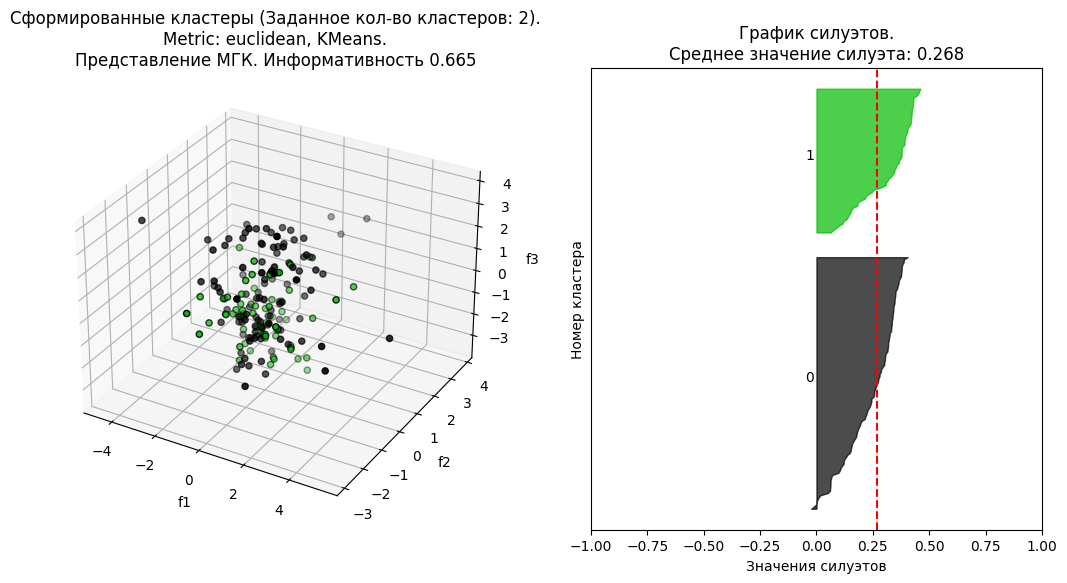

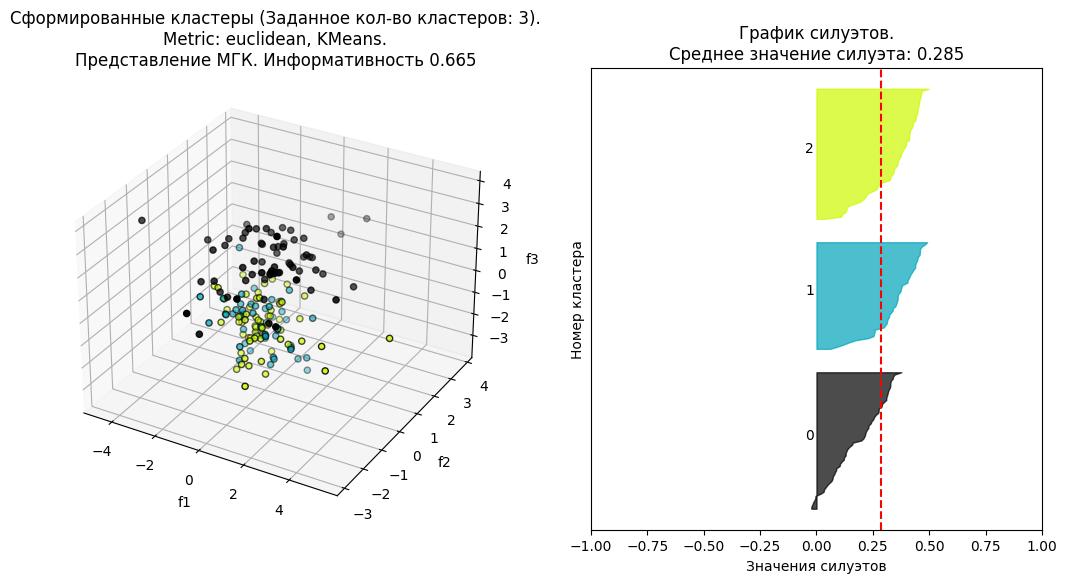

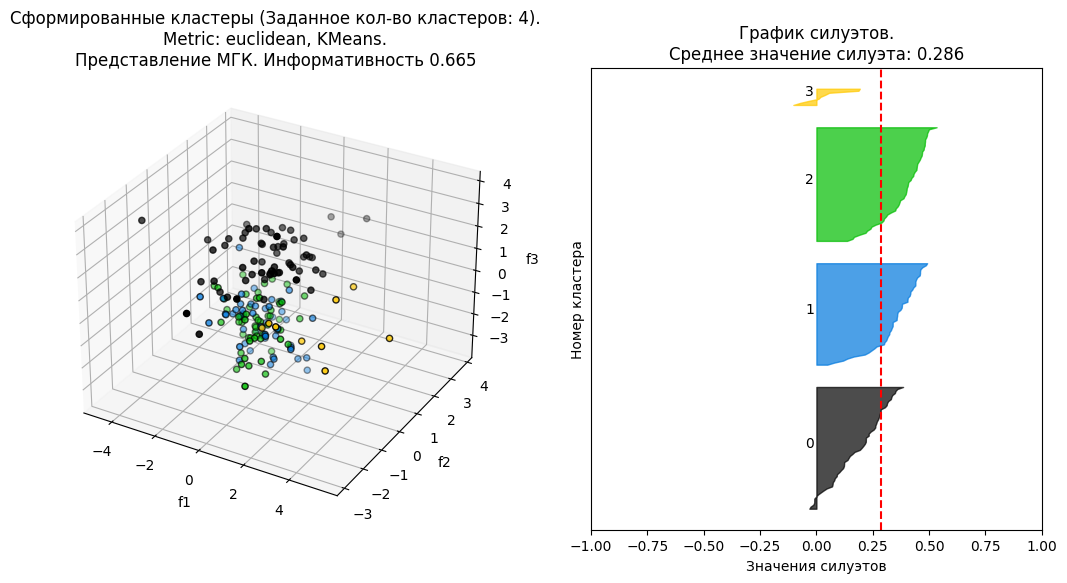

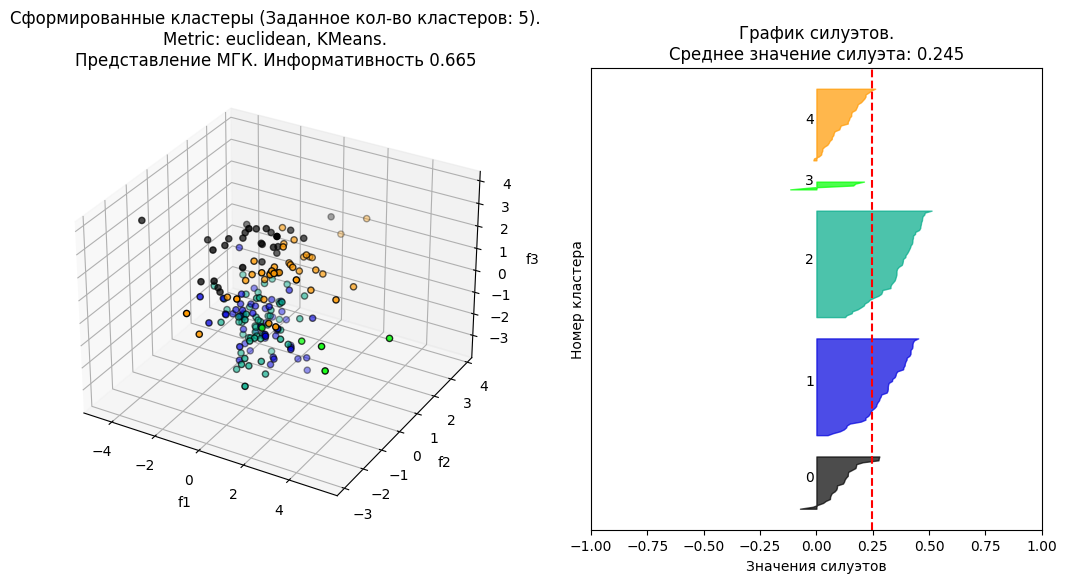

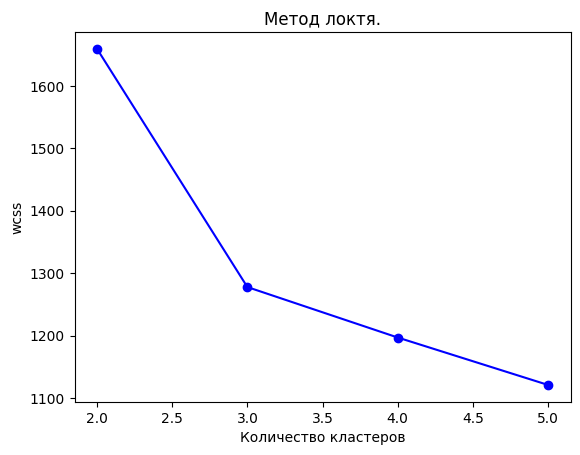

In [50]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_clusters_KMeans(data_x, n_clusters, metric='euclidean', as_subplot = False):
    '''Кластеризация по методу K-средних и построение результатов на 3д графике по МГК'''
    pca = PCA()
    x_pca = pca.fit_transform(data_x)
    x_pca_pd = pd.DataFrame(x_pca, columns=[ f'f{i}' for i in range(data_x.shape[1])])

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(x_pca_pd)
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    
    if as_subplot:
        ax = plt.figure(figsize=(12.8,6)).add_subplot(1, 2, 1, projection='3d')
    else:
        ax = plt.axes(projection='3d')
    z = x_pca_pd['f1']
    x = x_pca_pd['f2']
    y = x_pca_pd['f3']
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax.scatter(x, y, z, c=colors, marker='o', edgecolors=['000']*len(labels))
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.set_zlabel('f3')
    ax.set_title(f'Сформированные кластеры (Заданное кол-во кластеров: {n_clusters}).\nMetric: {metric}, KMeans.\nПредставление МГК. Информативность {sum(pca.explained_variance_ratio_[:3]):.3f}')
    return (labels, inertia)

def plot_silhouettes(silhouette_vals, labels):
    '''Построение графиков силуэтов'''
    n_clusters = len(set(labels))
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_vals[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples
    silhouette_avg = silhouette_score(data_x, labels)
    plt.title(f"График силуэтов.\nСреднее значение силуэта: {silhouette_avg:.3f}")
    plt.xlabel("Значения силуэтов")
    plt.ylabel("Номер кластера")
    plt.xlim(-1, 1)
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([]) # Clear the yaxis labels / ticks

def plot_wcss(n_clusters_var, inertias):
    '''Построение графика суммарного квадратичного отклонения'''
    plt.plot(n_clusters_var, inertias, '-bo')
    plt.ylabel('wcss')
    plt.xlabel('Количество кластеров')
    plt.title('Метод локтя.')

scaler = StandardScaler()
data_x = scaler.fit_transform(w_pd.iloc[:,:-1])

inertias = []
n_clusters_var = range(2, 6)
for clusters in n_clusters_var:
    labels, inertia = plot_clusters_KMeans(data_x, clusters, as_subplot=True)
    inertias.append(inertia)
    plt.subplot(1, 2, 2)
    silhouette_vals = silhouette_samples(data_x, labels)
    plot_silhouettes(silhouette_vals, labels)
    plt.show()
    
plot_wcss(n_clusters_var, inertias)
plt.show()

По построенной кластеризации методом К-средних сделаны графики силуэтов. Для количества кластеров равное или менее 3 практически все силуэты положительны и каждый класс имеет значения более среднего значения силуэтов. Смотря, на среднее значение, самые большие значения для количества кластеров от 2 до 4.

По методу локтя можно выбрать количество кластеров равным 3-4.

Итого, в данном датасете можно выделить от 2 до 4 кластеров.